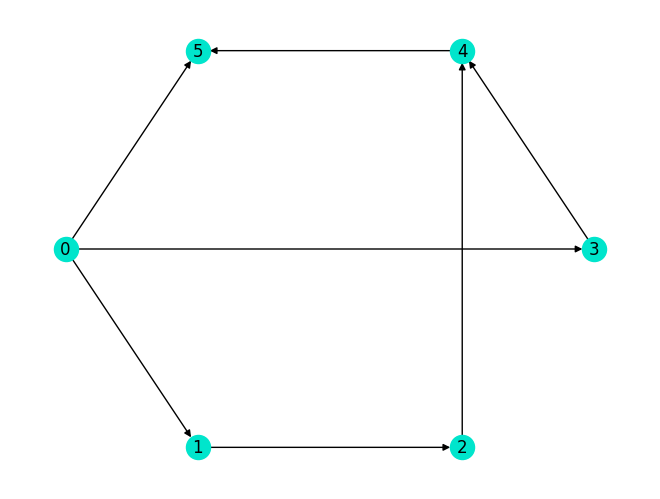

In [1]:
# Firstly, let's visualise our graph

import rustworkx as rx
from rustworkx.visualization import mpl_draw

num_nodes = 6
# The edge syntax is (start, end, weight)
edges = [(0, 1, None), (1, 2, None), (0, 3, None), (3, 4, None), (4, 5, None), (2, 4, None), (0, 5, None)]

# Make a directed acyclic graph
G = rx.PyDAG()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
layout = rx.digraph_shell_layout(G)
mpl_draw(G, layout, with_labels=True, node_color="#00e5cc")

In [2]:
# Taken from https://qiskit.org/ecosystem/ibm-runtime/tutorials/qaoa_with_primitives.html

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

%config InlineBackend.figure_format='retina'

In [6]:
service = QiskitRuntimeService()
backend = "ibmq_qasm_simulator"

In [26]:
import numpy as np
from qiskit.quantum_info import Pauli, SparsePauliOp

# Hypothetical data and values for the problem
# Replace these with actual data if desired

num_routes = 3

# Cost per kilometer per car for each route -> Thinnest route, route 1 will have a higher cost
congestion_costs = [12.0, 6.2, 4.0]  
distances = [1, 2, 3]  # Distances of each route in kilometers
num_cars = 500

def get_operator(congestion_costs, distances, num_cars) -> tuple[SparsePauliOp, float]:
    num_routes = len(congestion_costs)
    pauli_list = []
    coeffs = []
    shift = 0

    # Calculate the linear terms corresponding to congestion costs
    for i in range(num_routes):
        for j in range(num_cars):
            x_p = np.zeros(num_routes, dtype=bool)
            z_p = np.zeros(num_routes, dtype=bool)
            z_p[i] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(-0.5 * congestion_costs[i] * distances[i])
            shift += 0.5 * congestion_costs[i] * distances[i]

    # Calculate the quadratic terms for the capacity constraint
    for i in range(num_routes):
        for j in range(i + 1, num_routes):
            x_p = np.zeros(num_routes, dtype=bool)
            z_p = np.zeros(num_routes, dtype=bool)
            z_p[i] = True
            z_p[j] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(1.0)

    return SparsePauliOp(pauli_list, coeffs=coeffs), shift

# Example usage with hypothetical data and values

qubit_op, constant_shift = get_operator(congestion_costs, distances, num_cars)

# qubit_op now represents the Ising Hamiltonian, and offset is a constant shift
print("Ising Hamiltonian:")
print(qubit_op)
print("\nConstant shift:")
print(constant_shift)


Ising Hamiltonian:
SparsePauliOp(['IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 'IIZ', 

In [27]:
from typing import Union

from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info import Statevector
from qiskit.result import QuasiDistribution
from qiskit.utils import algorithm_globals

from qiskit_ibm_runtime import Sampler, Session

In [ ]:
from scipy.optimize import minimize

# Define the constraint function for the total number of cars
def constraint_total_cars(x):
    return np.sum(x) - 500

# Define the objective function to minimize congestion cost
def objective_function(x):
    total_cost = np.sum(x * np.array(congestion_costs))
    return total_cost

# Initial guess for the allocation of cars
x0 = np.array([1, 1, 1])  # You can adjust the initial guess

# Define the bounds for the number of cars per route
bounds = [(0, 50) for _ in range(len(congestion_costs))]  # Adjust the bounds as needed

# Define the equality constraint (total number of cars)
constraints = {'type': 'eq', 'fun': constraint_total_cars}

# Optimize the objective function with constraints
result = minimize(objective_function, x0, method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal allocation of cars
optimal_allocation = result.x

print(f"Optimal Allocation of Cars Per Route: {optimal_allocation}")
print(f"Minimum Total Congestion Cost: {result.fun}")

In [41]:
from typing import Union

from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info import Statevector
from qiskit.result import QuasiDistribution
from qiskit.utils import algorithm_globals

from qiskit_ibm_runtime import Sampler, Session


# def objective_value(x: np.ndarray, w: np.ndarray) -> float:
#     X = np.outer(x, (1 - x))
#     w_01 = np.where(w != 0, 1, 0)
#     return np.sum(w_01 * X)


def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part


def sample_most_likely(
    state_vector: Union[QuasiDistribution, Statevector]
) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)


algorithm_globals.random_seed = 10598
optimizer = COBYLA()

with Session(service=service, backend=backend):
    sampler = Sampler()
    qaoa = QAOA(sampler, optimizer, reps=2)
    result = qaoa.compute_minimum_eigenvalue(qubit_op)
    x = sample_most_likely(result.eigenstate)

print(f"Objective value computed by QAOA is {x}")

Objective value computed by QAOA is [1 0 0]


In [42]:
def total_congestion_cost(x: np.ndarray, qubit_op: SparsePauliOp, num_cars: int) -> float:
    """Compute the total congestion cost for a given allocation of cars to routes.
    Args:
        x: Binary string as numpy array representing the car allocation.
        qubit_op: Ising Hamiltonian representing the congestion costs.
        num_cars: Total number of cars to allocate.

    Returns:
        Total congestion cost.
    """
    # Calculate the objective value as the expectation value of the Ising Hamiltonian
    expectation_value = Statevector(x).expectation(qubit_op).real

    # Normalize by the total number of cars to get the total cost
    total_cost = -expectation_value / num_cars

    return total_cost


In [44]:
algorithm_globals.random_seed = 10598
optimizer = COBYLA()

with Session(service=service, backend=backend):
    sampler = Sampler()
    qaoa = QAOA(sampler, optimizer, reps=2)
    result = qaoa.compute_minimum_eigenvalue(qubit_op)
    x = sample_most_likely(result.eigenstate)

# Calculate the minimum total congestion cost
min_congestion_cost = total_congestion_cost(x, qubit_op, num_cars)

print(f"Minimum total congestion cost is {min_congestion_cost}")
print(f"Car allocation: {x}")


AttributeError: 'Statevector' object has no attribute 'expectation'